In [1]:
print("Let's Go!" )
from PIL import Image
import torch
from torchvision import transforms
import os
import shutil
import numpy as np
import time
from torch.optim import Adam
# from cleanfid import fid
import random 
from torch.nn import ReLU
from torch.nn import LayerNorm
import torch.nn.functional as F
from torch.nn.init import xavier_uniform_
from torch.nn import BatchNorm2d
from torch.nn import Parameter
from torch.nn import Linear
from torch.nn import DataParallel
from torch.nn import Sequential
from torch.nn import ConvTranspose2d
from torch.nn import GRUCell
from torch.nn import Module
from torch.nn import Flatten
from torch.nn.init import normal_
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import softmax
from torch.nn import Conv2d
from torch.nn import Conv1d
from torch.nn import MSELoss
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingLR
import sys
from tqdm import tqdm
from collections import OrderedDict
from torchvision.transforms import InterpolationMode
import matplotlib.pyplot as plt
torch.manual_seed(0)
np.random.seed(0)

print("torch version:" , torch.__version__)

Let's Go!
torch version: 2.1.2


In [2]:

images_val = '/kaggle/input/clevertex6-val/CLEVERTex6_val/CLEVERTex6_val_images'
masks_val = '/kaggle/input/clevertex6-val/CLEVERTex6_val/CLEVERTex6_val_masks'
clever6_indices_path = '/kaggle/input/clevertex6-val/CLEVERTex6_val/CLEVRTex6_val_indices.npy'
val_cluster_path = '/kaggle/input/clevertex6-val/CLEVERTex6_val/val_masks_clustering.npy'
clever6_indices = np.load(clever6_indices_path)
class ImageDatasetSlotAttention(Dataset):
    def __init__(self, images_folder , masks_folder , indices , transform , cluster_path):
        super(ImageDatasetSlotAttention , self).__init__()
        self.images_folder = images_folder
        self.masks_folder = masks_folder
        self.folder = images_folder
        self.transform = transform
        self.indices = indices
        self.all_clusters = np.load(cluster_path)
        print("indices shape:" , self.indices.shape)
        print("clusters data shape:" , self.all_clusters.shape)
        self.all_data =  self.build_data(images_folder)
        print("data size:" , len(self.all_data))
        del self.indices
        del self.all_clusters
        del self.transform 

    def build_data(self , folder_path):
        files = sorted(os.listdir(folder_path))
        files = sorted(files)
        data = []
        print("Loading data!")
        for idx in tqdm(self.indices):
            image_path = self.images_folder + f'/CLEVRTEX_full_{idx:06d}.png'
            image = Image.open(image_path).convert('RGB')
            cluster = torch.tensor(self.all_clusters[idx - 40000])
            data.append((self.transform(image) , cluster))
            
        print("Loaded data!")
        return data


    def __len__(self):
        return len(os.listdir(self.images_folder))
    def __getitem__(self , idx):
        return self.all_data[idx]

transform = transforms.Compose([
  transforms.PILToTensor(),
  transforms.ConvertImageDtype(torch.float),
  transforms.Normalize((0.5 ,  0.5 , 0.5), (0.5, 0.5 , 0.5)),
])


val_data = ImageDatasetSlotAttention(images_folder = images_val , masks_folder = masks_val,
                                    indices = clever6_indices , transform = transform,
                                    cluster_path = val_cluster_path)
print("image tensor max-min" , val_data[0][0].max().item() , val_data[0][0].min().item())
print("cluster tensor max-min" , val_data[4][1].max().item() , val_data[4][1].min().item())


indices shape: (5319,)
clusters data shape: (10000, 128, 128)
Loading data!


100%|██████████| 5319/5319 [00:41<00:00, 127.15it/s]

Loaded data!
data size: 5319
image tensor max-min 0.8588235378265381 -0.9843137264251709
cluster tensor max-min 6 0


In [3]:
class Block(Module):
    def __init__(self, channels):
        super(Block, self).__init__()
        self.downsample = Sequential(OrderedDict([
            ('conv1' , Conv2d(channels, channels, kernel_size = 5 , stride = 1 , padding = 2)),
            ('bn1'   , BatchNorm2d(channels)),
            ('relu1' , ReLU()),
            ('conv2' , Conv2d(channels, channels, kernel_size = 5 , stride = 1 , padding = 2)),
            ('bn2'   , BatchNorm2d(channels))
        ]))
        
        self.relu = ReLU()

    def forward(self, x):
        return self.relu(x + self.downsample(x))

class BlockUp(Module):
    def __init__(self , in_channels , out_channels):
        super(BlockUp, self).__init__()
        
        self.downsample = Sequential(OrderedDict([
            ('conv1' , Conv2d(in_channels , out_channels , kernel_size = 5 , stride = 1 , padding = 2)),
            ('bn1'   , BatchNorm2d(out_channels)),
            ('relu1' , ReLU()),
            ('conv2' , Conv2d(out_channels , out_channels , kernel_size = 5 , stride = 1 , padding = 2)),
            ('bn2'   , BatchNorm2d(out_channels)),
        ]))
        self.skip = Sequential(OrderedDict([
            ('conv1' , Conv2d(in_channels , out_channels, kernel_size = 5 , stride = 1 , padding = 2)),
            ('bn1'   , BatchNorm2d(out_channels))
        ]))
        self.relu = ReLU()



    def forward(self, x):
        return self.relu(self.skip(x) + self.downsample(x))
    
    
class ResNet18(Module):
    def __init__(self):

        super(ResNet18, self).__init__()
        layer0 = Sequential(OrderedDict([
         ('conv' , Conv2d(3 , 16 , kernel_size = 5 , stride = 1 , padding = 2)),
         ('bn'   , BatchNorm2d(16)),
         ('relu' , ReLU())
        ]))

        self.resnet = Sequential(OrderedDict([
            ('layer0' , layer0),
            ('block1' , Block(16)),
            ('block2' , Block(16)),
            ('block3' , BlockUp(16 , 32)),
            ('block4' , Block(32)),
            ('block5' , Block(32)),
            ('block6' , BlockUp(32 , 64)),
            ('block7' , Block(64)),
            ('block8' , Block(64))
        ]))


    def forward(self, x):
        return self.resnet(x)


In [4]:


class ObjectDiscovery(Module):
    def __init__(self , encoder_resolution ,  decoder_resolution , T   , K , D_slots):
        super(ObjectDiscovery , self).__init__()
        print(f'Initialized ObjectDiscovery!')
        self.layers = Sequential(OrderedDict([
          ("encoder" , ImageEncoder(resolution = encoder_resolution , T = T,
                                    K = K , D_slots = D_slots )),
          ("decoder" , SlotAttentionDecoder(resolution = decoder_resolution , K = K , D_slots = D_slots))
        ]))
    def forward(self , image):
        return self.layers(image)

class PositionEncoder(Module):
    def __init__(self, output_dim , resolution):
        super(PositionEncoder , self).__init__()
        self.linear =  Linear(in_features = 4 , out_features = output_dim)
        # above is equivalent to a linear layer
        self.grid = Parameter(data = PositionEncoder.build_grid(resolution) , requires_grad = False)
        print("Grid shape:" , self.grid.shape)

    @staticmethod
    def build_grid(resolution):
        ranges = [np.linspace(start = 0.0 , stop = 1.0 , num = dimension) for dimension in resolution] # dim = (2 , 128)
        grid = np.meshgrid(*ranges , sparse = False, indexing = "ij") # dim = (128 , 128)
        # row[i] of grid[0] has all elements i / 127 and col[j] of grid[1] has all elements j / 127
        grid = np.stack(grid , axis = -1) # dim = (64 , 64 , 2) to match conv later
        grid = np.expand_dims(grid, axis = 0) # dim = (1 , 64 , 64 , 2) for batch dimension
        grid = grid.astype(np.float32) # PyTorch throws an error later otherwise
        return torch.tensor(np.concatenate([grid , 1.0 - grid] , axis = 3)) # (1 , 64 , 64 , 4)


    def forward(self, x): # x has shape (batch , 64 , 64 , D_inputs)
        return x + self.linear(self.grid)


class ImageEncoder(Module):
    def __init__(self , resolution , T  ,  K , D_slots):
        super(ImageEncoder , self).__init__()
        print(f'Initialized ImageEncoder! resolution: {resolution}')
        D_inputs = 64
        self.encoder_cnn = ResNet18()
        down_resolution = (128 , 128)
        positional_encoder = PositionEncoder(output_dim =  D_inputs , resolution = down_resolution)


        slot_attention = SlotAttention(T = T , K = K , D_slots = D_slots)
        self.pos_encode_feedforward_slotattn = Sequential(OrderedDict([
            ("pos_encoder" , positional_encoder), #  (batch , 64 , 64 , D_inputs)
            ("flatten" , Flatten(start_dim = 1 , end_dim = 2)), # (batch , 64 * 64 , D_inputs)
            ("layer_norm" ,  LayerNorm(normalized_shape = 64)), # (batch , 64 * 64 , D_inputs)
            ("linear1:" , Linear(in_features = 64 , out_features = 128)),
            ("relu1:"   , ReLU()),
            ("linear2:" , Linear(in_features = 128 , out_features = 128)),
            ("slot_attention" , slot_attention) #  (batch , K , D_slots)
        ]))
    # feature map has shape (channels , h , w)
    # N is h * w i.e. each pixel is a different feature "vector", size of this vector of D_inputs = # of channels
    # channels = D_inputs , h * w = N
    def forward(self , x): # x is aimge with shape (batch , 3 , 126 , 128)
        x = self.encoder_cnn(x).permute(dims = (0 , 2 , 3 , 1))  # (batch , 64 , 64 , D_inputs)
        return self.pos_encode_feedforward_slotattn(x)



class SlotAttention(Module):
    def __init__(self , T, K , D_slots  , epsilon = 1e-8):
        super(SlotAttention , self).__init__()
        print(f'Initialzing SlotAttention parameters: T: {T} , K: {K} , D_slots: {D_slots}')
        self.T = T
        self.K = K
        self.D_slots = D_slots
        self.epsilon = epsilon

        self.norm_inputs = LayerNorm(normalized_shape =  128)
        self.query_from_slots  = Sequential(OrderedDict([
            ("NormSlots" , LayerNorm(normalized_shape = D_slots)),
            ("SlotQuery" , Linear(in_features = D_slots  , out_features = D_slots , bias = False))
        ]))


#         self.slots_init = Parameter(data = normal_(torch.empty(1 , K , D_slots)) , requires_grad = True)

        self.init_latents = Parameter(normal_(torch.empty(1 , self.K , self.D_slots)))



        self.keys_from_inputs  = Linear(in_features = 128 , out_features = D_slots , bias = False)
        self.vals_from_inputs  = Linear(in_features = 128 , out_features = D_slots , bias = False)
        self.gru = GRUCell(input_size = D_slots , hidden_size = D_slots)
        self.norm_feed = Sequential(OrderedDict([
            ("layer_norm" ,  LayerNorm(normalized_shape = D_slots)),
            ("linear1" , Linear(in_features = D_slots , out_features = 256)),
            ("relu1"   , ReLU()),
            ("linear2" , Linear(in_features = 256 , out_features = D_slots))
        ]))


    def forward(self, inputs):
        batch_size = inputs.shape[0]
        inputs = self.norm_inputs(inputs)
        keys = self.keys_from_inputs(inputs)
        vals = self.vals_from_inputs(inputs)
        slots = self.init_latents.repeat(batch_size , 1 , 1)
        for _ in range(self.T):
            slots_prev = slots
            queries = self.query_from_slots(slots)
            attn_logits = (self.D_slots ** -0.5) * torch.einsum('bnc,bmc->bnm', keys , queries)
            attn = F.softmax(attn_logits , dim = -1)
            attn = attn + self.epsilon
            attn = attn / torch.sum(attn, dim = 1, keepdim = True)
            updates = torch.einsum('bnm,bnc->bmc' , attn , vals)
            slots = self.gru(
                updates.view(batch_size * self.K , self.D_slots),
                slots_prev.view(batch_size * self.K , self.D_slots),
            )
            slots = slots.view(batch_size , self.K , self.D_slots)
            slots = slots + self.norm_feed(slots)

        return slots


class SlotAttentionDecoder(Module):
    def __init__(self , resolution , K , D_slots):
        super(SlotAttentionDecoder , self).__init__()
        print(f'Initialized SlotAttentionDecoder! resolution: {resolution}')
        print(f'Decoder parameters: K: {K} , D_slots: {D_slots}')
        self.resolution = resolution
        self.positional_encoder = PositionEncoder(output_dim = D_slots , resolution = resolution)

        self.K = K
        self.D_slots = D_slots

        self.decoder_cnn = Sequential(OrderedDict([
            ("conv1" , ConvTranspose2d(in_channels = D_slots , out_channels = 64 , kernel_size = 5 , stride = 2 , padding = 2 , output_padding = 1)),
            ('relu1' , ReLU()),
            ("conv2" , ConvTranspose2d(in_channels = 64 , out_channels = 64 , kernel_size = 5 , stride = 2 , padding = 2 , output_padding = 1)),
            ('relu2' , ReLU()),
            ("conv3" , ConvTranspose2d(in_channels = 64 , out_channels = 64 , kernel_size = 5 , stride = 2 , padding = 2 , output_padding = 1)),
            ('relu3' , ReLU()),
            ("conv4" , ConvTranspose2d(in_channels = 64 , out_channels = 64 , kernel_size = 5 , stride = 2 , padding = 2 , output_padding = 1)),
            ('relu4' , ReLU()),
            ("conv5" , ConvTranspose2d(in_channels = 64 , out_channels = 4 , kernel_size = 1 , stride = 1)),
        ]))


    def forward(self , slots):
        # slots comes form the ImageEncoder shape : (batch , K , D_slots)
        batch_size = slots.shape[0]
        x =  slots.view(batch_size * self.K , 1 , 1 , self.D_slots)
        x = x.repeat(1 , self.resolution[0] , self.resolution[1] , 1)
        x = self.positional_encoder(x).permute(0 , 3 , 1 , 2)
        x = self.decoder_cnn(x) # dim = (batch * K , 4 , 128 , 128)
        x = x.view(batch_size, self.K , 4 , 128 , 128)# dim = (batch , K , 4 , 128 , 128)
        recons , masks = x[: , : , : 3 , : , :]  , x[: , : , -1 : , : , :]
        masks = F.softmax(masks , dim = 1) # dim = (batch , K , 1 , 128, 128)
        reconstructed = torch.sum(recons * masks , dim = 1) # dim = (batch , 3 , 128, 128)
        return reconstructed , recons , masks

In [5]:
model_path = '/kaggle/input/v17-model-180/model_180'
print("Loading model!")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:" , device)
model_dict = torch.load(model_path)
model = ObjectDiscovery(encoder_resolution = (128 , 128) , decoder_resolution = (8 , 8),
                    T = 3 ,  K = 7 , D_slots = 128)
model.to(device)


new_dict = {}
for key in model_dict['model_state_dict']:
    assert key[0 : 7] == 'module.'
    new_dict[key[7 : ]] = model_dict['model_state_dict'][key]
    
model.load_state_dict(new_dict)
# model.load_state_dict(model_dict['model_state_dict'])
encoder_model = model.layers.encoder
decoder_model = model.layers.decoder
model.eval()
encoder_model.eval()
decoder_model.eval()
for key in model_dict:
    if key == 'model_state_dict' or key == 'optimizer_state_dict':
        continue
    print(f'{key}: {model_dict[key]}')

print("Loaded model!")


Loading model!
Using device: cuda
Initialized ObjectDiscovery!
Initialized ImageEncoder! resolution: (128, 128)
Grid shape: torch.Size([1, 128, 128, 4])
Initialzing SlotAttention parameters: T: 3 , K: 7 , D_slots: 128
Initialized SlotAttentionDecoder! resolution: (8, 8)
Decoder parameters: K: 7 , D_slots: 128
Grid shape: torch.Size([1, 8, 8, 4])
epoch: 179
train_loss: 0.019978486949544468
Loaded model!


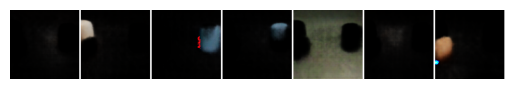

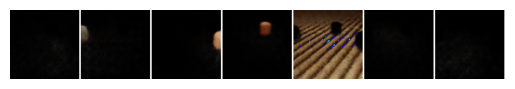

In [6]:
def show_image(image , file):
    plt.imshow(image)
    image = np.clip(image , 0 , 255)
    plt.axis('off') 
    plt.show()
    pil = Image.fromarray(image)
    pil.save(file + '.png')
    
idx = 4092
white_strip = 255 * np.ones((128 , 3 , 3) , dtype = np.uint8)
with torch.no_grad():
    image = val_data[idx][0].to(device)
    reconstructed , recons , mask = model(image.unsqueeze(0))
    image  = (255 * (0.5 * image.cpu().numpy().transpose(1, 2, 0) + 0.5)).astype(np.uint8)
#     show_image(image , f'gen_image_{idx}.png')
    slot_images1 = np.zeros((128 , 0 , 3) , dtype = np.uint8)
    for k in range(7): # 1 6 4 0 
        img = mask[0][k] * (0.5 * recons[0][k] + 0.5)
        img = (255 * img.cpu().numpy().transpose(1, 2, 0)).astype(np.uint8)
        slot_images1 = np.concatenate((slot_images1 , img , white_strip) , axis = 1)
    show_image(slot_images1 , "slots_images_1")
idx = 1086
with torch.no_grad():
    image = val_data[idx][0].to(device)
    reconstructed , recons , mask = model(image.unsqueeze(0))
    image  = (255 * (0.5 * image.cpu().numpy().transpose(1, 2, 0) + 0.5)).astype(np.uint8)
#     show_image(image , f'gen_image_{idx}.png')
    slot_images2 = np.zeros((128 , 0 , 3) , dtype = np.uint8)
    for k in range(7): # 2 3 6 
        img = mask[0][k] * (0.5 * recons[0][k] + 0.5)
        img = (255 * img.cpu().numpy().transpose(1, 2, 0)).astype(np.uint8)
        slot_images2 = np.concatenate((slot_images2 , img , white_strip) , axis = 1)

    show_image(slot_images2 , "slots_images_2")
        
        
        
    


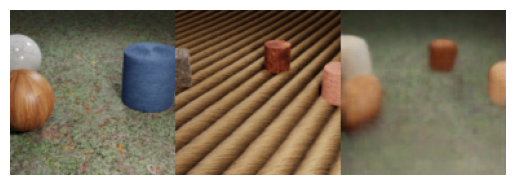

In [7]:
mixed_slots = []

image1 = val_data[4092][0].to(device)
with torch.no_grad():
    slots = encoder_model(image1.unsqueeze(0))
    mixed_slots.append(slots[: , 0 : 1 , :])
    mixed_slots.append(slots[: , 1 : 2 , :])
    mixed_slots.append(slots[: , 4 : 5 , :])
    mixed_slots.append(slots[: , 6 : 7 , :])
    
image2 = val_data[1086][0].to(device)
with torch.no_grad():
    slots = encoder_model(image2.unsqueeze(0))
    mixed_slots.append(slots[: , 2 : 3 , :])
    mixed_slots.append(slots[: , 3 : 4 , :])
    mixed_slots.append(slots[: , 6 : 7 , :])
mixed_slots = torch.cat(mixed_slots , dim = 1)
decode = decoder_model(mixed_slots)[0].squeeze(0)
decode = (255 * (0.5 * decode.detach().cpu().numpy().transpose(1, 2, 0) + 0.5)).astype(np.uint8)
image1 = (255 * (0.5 * image1.cpu().numpy().transpose(1, 2, 0) + 0.5)).astype(np.uint8)
image2 = (255 * (0.5 * image2.cpu().numpy().transpose(1, 2, 0) + 0.5)).astype(np.uint8)
plt_image = np.concatenate((image1 , image2 , decode) , axis = 1)
show_image(plt_image , "mixed_1")
    
    

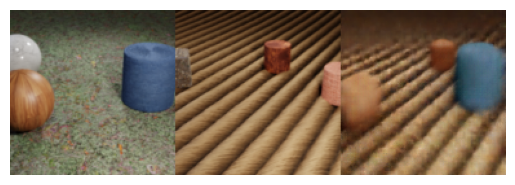

In [8]:
# 0 2 3 
# 0 1 3 4 
mixed_slots = []

image1 = val_data[4092][0].to(device)
with torch.no_grad():
    slots = encoder_model(image1.unsqueeze(0))
    mixed_slots.append(slots[: , 0 : 1 , :])
    mixed_slots.append(slots[: , 2 : 3 , :])
    mixed_slots.append(slots[: , 3 : 4 , :])
    mixed_slots.append(slots[: , 6 : 7 , :])
    

    
image2 = val_data[1086][0].to(device)
with torch.no_grad():
    slots = encoder_model(image2.unsqueeze(0))
    mixed_slots.append(slots[: , 0 : 1 , :])
    mixed_slots.append(slots[: , 3 : 4 , :])
    mixed_slots.append(slots[: , 4 : 5 , :])
    
mixed_slots = torch.cat(mixed_slots , dim = 1)
decode = decoder_model(mixed_slots)[0].squeeze(0)
decode = (255 * (0.5 * decode.detach().cpu().numpy().transpose(1, 2, 0) + 0.5)).astype(np.uint8)
image1 = (255 * (0.5 * image1.cpu().numpy().transpose(1, 2, 0) + 0.5)).astype(np.uint8)
image2 = (255 * (0.5 * image2.cpu().numpy().transpose(1, 2, 0) + 0.5)).astype(np.uint8)
plt_image = np.concatenate((image1 , image2 , decode) , axis = 1)
show_image(plt_image , "mixed_2")
    
    